[원본 노트북](https://www.kaggle.com/code/sammir/end-to-end-nlp-eda-ml-with-sentiment-analysis/data)

# End-to-End NLP (EDA & ML) with Sentiment Analysis

In this notebook we are going to go through on how to perform text classification using logistic regression and several text encoding techniques such as bag of words and tf-idf. Our dataset contains the movie review data with labeled sentiment class of 0,1,2,3 and 4 where 0 is negative, 1 somehow negative, 2 neutral, 3 somehow positive and 4 positive.

We will start with Exploratory Data Analysis then perform machine learning modeling.


# 0. Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# nltk : natural language toolkit 패키지
# 교육용으로 개발된 자연어 처리 및 문서 분석용 파이썬 패키지
# 말뭉치, 토큰생성, 형태소 분석, 품사 태깅 등의 기능 제공
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
# 문서에 사용된 단어(토큰)의 사용빈도 정보를 담는 클래스
from nltk import ngrams
# ngrams : 총 n개의 단어의 그룹 내에서 n번째 단어 이전의 n-1 개의 단어에 기반해
# 다음에 올 단어를 예측하는 모델입니다. 단어들의 집합에 확률을 부여하는 방식으로
# 다음에 올 단어를 맞추게 되는데, 기본적으로 조건부확률을 기반으로 추정하게 됩니다.

import string, re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings, os

n gram 모델의 조건부확률 식  
$P(x_i | x_{i-(n-1)},...,x_{i-1})$  
* 데이터셋에 존재하지 않는 단어의 조합은 추정이 어렵다.
* N 개수를 증가시키는 것은 모델의 성능을 높일 수 있지만, 모델 사이즈 증가에 따른 비용 문제가 된다.  
두가지 문제점이 존재합니다. 그래서 최근에는 이를 해결하기 위해 딥러닝에 기반한 언어모델들이 주로 사용되고 있습니다.

[n-gram](https://seanpark11.tistory.com/89?category=962465)

In [2]:
plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1152x504 with 0 Axes>

## 1) Load Data

In [3]:
# cd /content/drive/MyDrive/dataset/kaggle/End-to-End_NLP
# !unzip test.tsv.zip
# !unzip train.tsv.zip

In [4]:
# locate the data directories
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/kaggle'):
    for filename in filenames : 
        print(os.path.join(dirname, filename))

# dirname, filename을 해당 경로 내에 있는 놈들 다 수집
# 수집한놈들 filenames에서 하나씩 꺼내서 dirname이랑 filename이랑 합치기

/content/drive/MyDrive/dataset/kaggle/End-to-End_NLP/sampleSubmission.csv
/content/drive/MyDrive/dataset/kaggle/End-to-End_NLP/test.tsv.zip
/content/drive/MyDrive/dataset/kaggle/End-to-End_NLP/train.tsv.zip


In [5]:
train=pd.read_csv('/content/drive/MyDrive/dataset/kaggle/End-to-End_NLP/train.tsv.zip', sep='\t')
test=pd.read_csv('/content/drive/MyDrive/dataset/kaggle/End-to-End_NLP/test.tsv.zip', sep='\t')

# 1. Part 1 Exploratory Data Analysis

In [6]:
train.shape, test.shape

((156060, 4), (66292, 3))

In [7]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [10]:
train.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of         PhraseId  SentenceId  Phrase  Sentiment
0          False       False   False      False
1          False       False   False      False
2          False       False   False      False
3          False       False   False      False
4          False       False   False      False
...          ...         ...     ...        ...
156055     False       False   False      False
156056     False       False   False      False
156057     False       False   False      False
156058     False       False   False      False
156059     False       False   False      False

[156060 rows x 4 columns]>

In [11]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

null값은 없고요

In [12]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


왜또불렀지

## Sentiment Description

In [13]:
train['sentiment_class'] = train['Sentiment'].map({0:'negative', 1:'somewhat negative', 2:'neutral', 3:'somewhat positive', 4:'positive'})
# 새 클래스 만들어가지고요 거기다가 sentiment의 각각 값에 mapping한당!
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


0 negative  
1 somewhat negative  
2 neutral  
3 somewhat positive  
4 positive  
로 바꿔줬습니다! 보통은 숫자형태로 바꿔주는데말입니다? nlp라서?그런거임?

## Remove Punctuations (문장부호 제거)

In [14]:
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])
    

In [15]:
a = '아유... 배고파..??@@!'
print(remove_punctuation(a))


아유 배고파


In [62]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

성능은 확실하군뇨  
remove_punctuation 함수는 'string.punctuation' , 그러니까 구두점들의 집합! 중에 text에서 포함되지 않는게 있다면 t라고 하고 그 t들을 join한 것이에요 ""라고 했으니까 공백이 안들어가는거에요 사이에!

In [16]:
train['Phrase']=train['Phrase'].apply(lambda x:remove_punctuation(x))
# 앞서 만든 함수 바아로 적용
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


## Remove words with less than 2 characters

In [17]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>3])

3글자 이하는 지워줄거에요  
근데이제 " "로 join해줌 text를 공백으로쪼개서 t라고 한담에 그 t가 3보다 큰놈들에 한해서 join해줌;;;

In [18]:
train['Phrase']=train['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage that what...,1,somewhat negative
1,2,1,series escapades demonstrating adage that what...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


아까 A 만 있던 index 3의 phrase가 지워졌군요

근데 함수 이름너무한거아니니?;  
def 세_글자_보다_큰__단어 : 콱시

## Remove Stopwords

In [19]:
import nltk
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

일케 다운받아야 되더라 ; 안돼서 stackoverflow검색해봄

In [20]:
stop_words=stopwords.words('english')
train['Phrase']=train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


## check sentiment categories

In [21]:
train.groupby('Sentiment')['Sentiment'].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

sentiment로 묶어서 각 수치마다 개수를셌어요

## Visualize the target variables

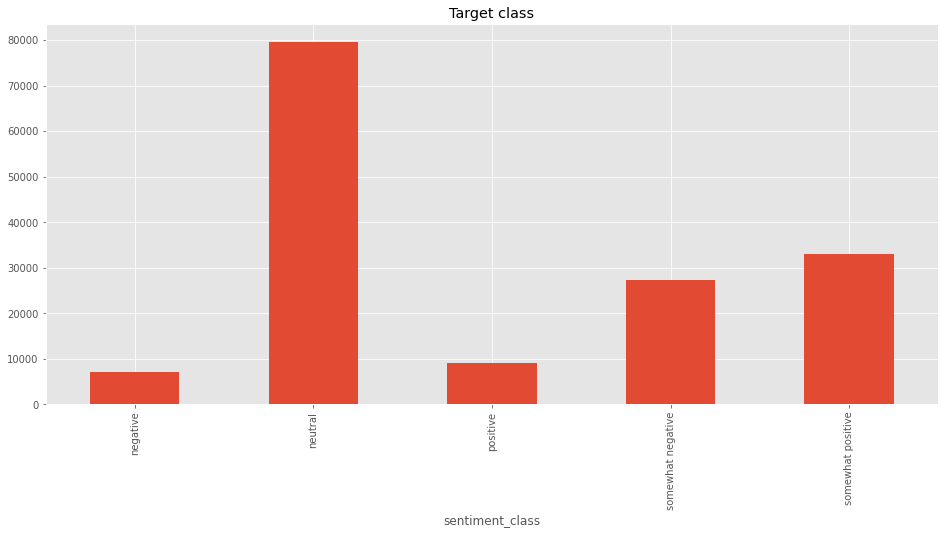

In [22]:
train.groupby('sentiment_class')['sentiment_class'].count().plot(kind='bar', title='Target class', figsize=(16,7), grid=True)

아까 mapping해뒀던 sentiment_class를 기준으로 숫자 세서 plot 그렸어요  
groupby한거 뒤에 `.plot`으로 바로 plot 그릴수있는게 꿀팁이내요

neutral 이 가장 많습니다ㅡ.

## Get percentages of each class

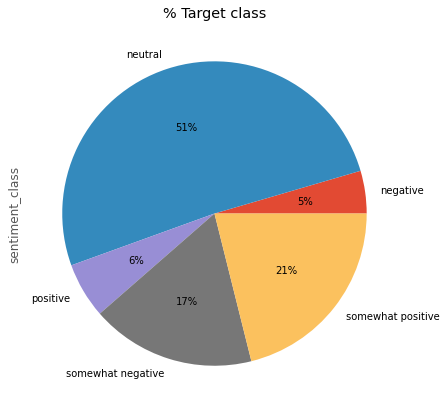

In [23]:
((train.groupby('sentiment_class')['sentiment_class'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

target class를 pie 그래프로 표현했습니다.  
train shape로 나눠서 100을 곱해서 퍼센트형식으로 보이게 했음.. 그러고 서식을 autopct 옵션으로 % 지정해줌 1.1하면 소수점 첫째자리까지

## Adding phrase length

In [66]:
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))

phrase length를 len함수로 세어주고 새 컬럼 phraselength를 만들어서 넣어줌

In [67]:
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,207,"[Filmmakers, Dana, JanklowiczMann, Amir, Mann,..."
62992,62993,3189,addition sporting worst titles recent cinemati...,0,negative,200,"[addition, sporting, worst, titles, recent, ci..."
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,199,"[movie, biggest, shocks, come, seeing, former,..."
62500,62501,3162,While transgressive trappings especially frank...,1,somewhat negative,197,"[While, transgressive, trappings, especially, ..."
72577,72578,3708,Stephen Earnhart documentary decomposition hea...,1,somewhat negative,196,"[Stephen, Earnhart, documentary, decomposition..."


잘 만들어졌네용

## Distribution of phrase length on each class

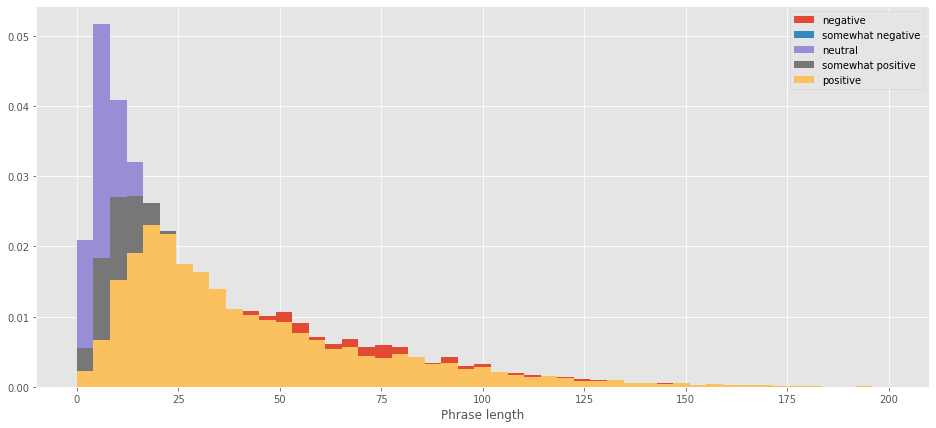

In [26]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'], bins=bins, density=True, label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'], bins=bins, density=True, label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'], bins=bins, density=True, label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'], bins=bins, density=True, label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'],bins=bins, density=True, label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

히스토그램을 그릴거에용  
bins = 사각형 개수 촘촘한 정도 
linspace(start,stop,num) = 배열 만들어주는 함수  
linspace(0,200,50) = 0부터 200사이에 50개의 간격을 갖는 배열을 만드셈
각각 히스토그램을 그리는ㄴ 코드는 sentiment_class의 값이 negative거나~ 뭐~ 해당하는 컬럼값이면~ phraselength 값을 x로 해서 그림을 그려라는 것 아닐까나?

## Common words with word cloud

In [27]:
# !pip install wordcloud

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


wordcloud 설치합쉬당~  
단어 시각화하는 모듈인듯

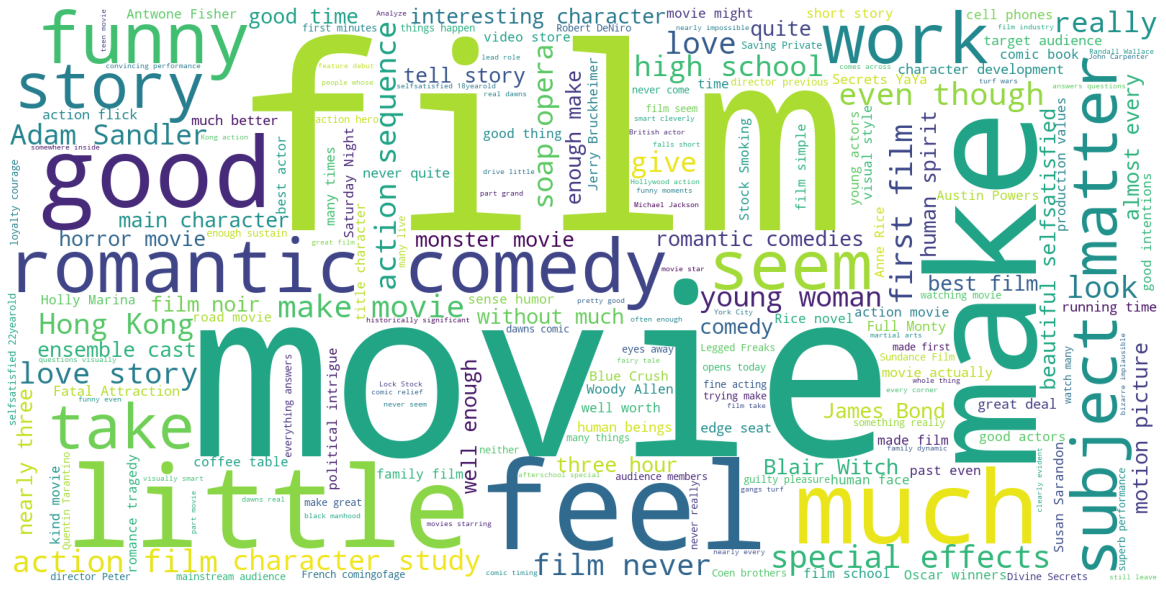

In [29]:
word_cloud_common_words=[]
for index, row in train.iterrows():
    word_cloud_common_words.append((row['Phrase']))

word_cloud_common_words

wordcloud = WordCloud(width =1600, height = 800, background_color='white', 
                      stopwords = stopwords,
                      min_font_size = 5).generate(''.join(word_cloud_common_words))


# plot the WordCloud image
plt.figure(figsize = (16,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

movie, film이 가장 크게 나왔네용

In [32]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
text_list=[]
for index, row in train.iterrows():
    text_list.append((row['Phrase']))

text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)


text_list를 만들고, iterrows 함수를 활용, index와 row를 가져옵니다.  
text_list에 Phrase 행정보만 추가합니다.  
[iterrows + for](https://dschloe.github.io/python/pandas/iterrows/)

total_words에는 이렇게 모은 text_list를 합쳐서 담아줍니다.
담아준 것들로 token화합니다!

In [35]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

nltk의 함수인freqDist를 사용해서 단어의 빈도수를 구해봅니다.

In [36]:
# 10 common words
print(word_frequency.most_common(10))

[('film', 3259), ('movie', 2892), ('like', 1968), ('story', 1204), ('much', 1085), ('good', 1069), ('even', 1041), ('characters', 994), ('little', 976), ('make', 838)]


아까 시각화에서 본 것처럼 film이 가장 많네요

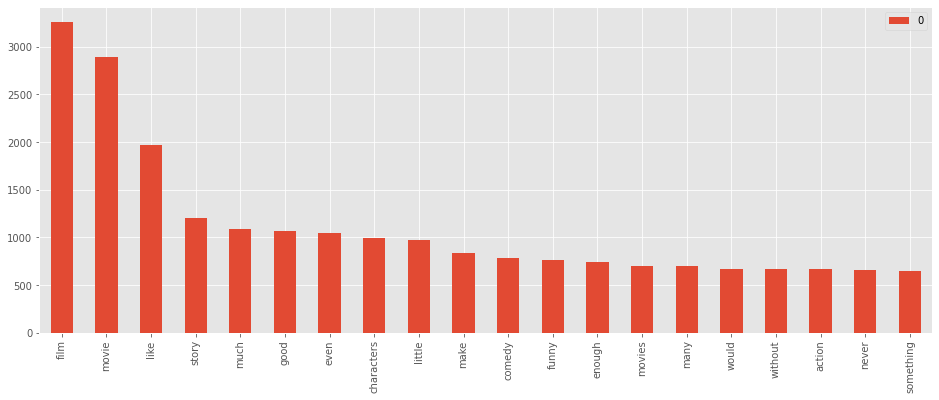

In [37]:
# visualize
pd.DataFrame(word_frequency, index=[0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind='bar', figsize=(16,6), grid=True)

중간에 .T를 볼 수 있는데 요것은 로우와 컬럼을 바꾸는 것입니다!  
transpose의 약자인듯 싶습니다.

## Common Words used for positive sentiment

In [38]:
pos_text_list=[]
for index, row in train[train['Sentiment']==4].iterrows():
    pos_text_list.append((row['Phrase']))

pos_text_list

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

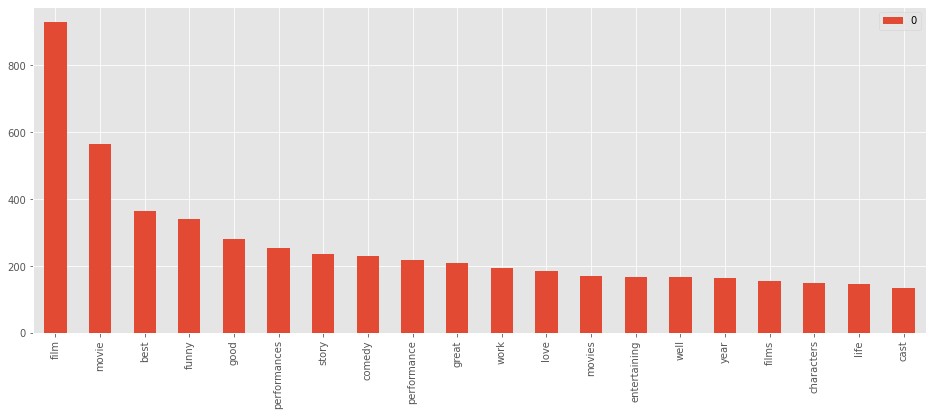

In [39]:
# visualize

pd.DataFrame(pos_word_frequency,index=[0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

head(20)에 한해서 그래프를 그릴 수도 있네용  
sentiment 4에 해당하는 (positive) 데이터에서 최빈 단어를 그래프로 그렸습니다.

## Common bigram words used for positive sentiment

In [40]:
text="Tom and Jerry love micky, But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends"

bigram_frequency = FreqDist(ngrams(word_tokenize(text), 3))
bigram_frequency.most_common()[0:5]

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'micky'), 1),
 (('love', 'micky', ','), 1),
 (('micky', ',', 'But'), 1)]

톰과 제리 어쩌고 문장을 토큰화 하고 ngram을 사용해서 다음에 올것같은 3개의 단어를 추출한건가요?

In [41]:
text_list=[]
for index, row in train.iterrows():
    text_list.append((row['Phrase']))

text_list

total_words = ' '.join(text_list)
total_words = word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:5]

[(('film', 'movie'), 1),
 (('movie', 'like'), 1),
 (('like', 'story'), 1),
 (('story', 'good'), 1),
 (('good', 'characters'), 1)]

빈도수로 추출한거니까 결과가 노트북이랑 같아야 하는것 아닌지?
ngram이 조건부확률기반이라서 그런거야?

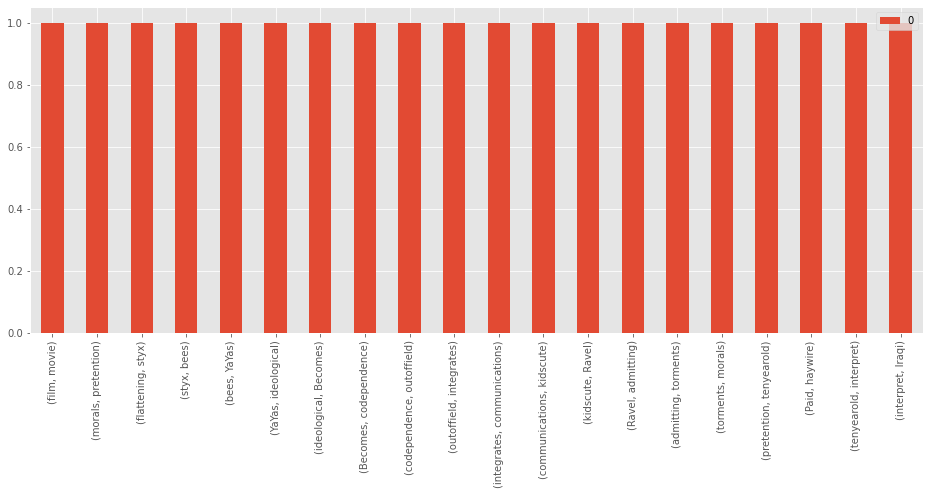

In [42]:
# visualize

pd.DataFrame(word_frequency, index= [0]).T.sort_values(by=[0], ascending = False).head(20).plot(kind='bar', figsize=(16,6),grid=True)

다 1이라서 저렇게 나옴 왜 시각화한거지

# Part 2 Machine Learning Modeling

## Prepare Training data

dtm : 문서 단어 행렬  
다수 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현한 것.  

### Create Bag of words with CountVectorizer

In [43]:
train['tokenized_words'] = train['Phrase'].apply(lambda x : word_tokenize(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


phrase를 tokenized 한 단어들을 컬럼 생성해서 담아줍니다. word_tokenize함수를사용해서!

In [44]:
count_vectorizer = CountVectorizer()
phrase_dtm=count_vectorizer.fit_transform(train['Phrase'])

count_vectorizer로 가방을 만들어줌


In [45]:
phrase_dtm.shape

(156060, 15746)

## Split data into training and validation sets (70:30) ratio


In [46]:
X_train, X_val, y_train, y_val = train_test_split(phrase_dtm, train['Sentiment'], test_size=0.3, random_state=38)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

## Train Logistic Regression Model


In [47]:
model = LogisticRegression()

In [48]:
model.fit(X_train, y_train)

LogisticRegression()

## Measure model performance

In [49]:
accuracy_score(model.predict(X_val), y_val)* 100

63.75752915545303

## free up memory for tf-idf

In [50]:
del X_train
del X_val
del y_train
del y_val

왜지움? tf-idf 쓸거니까!

## Preparing data with tf-idf

tf-idf(Term Frequency-Inverse Document Frequency)  
단어의 빈도와 역문서 빈도를 사용해서 DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법 우선 dtm을 만드러야댐  


In [51]:
tfidf=TfidfVectorizer()
tfidf_dtm=tfidf.fit_transform(train['Phrase'])

In [52]:
X_train, X_val, y_train, y_val = train_test_split(tfidf_dtm, train['Sentiment'], test_size=0.3, random_state=38)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

In [53]:
tfidf_model=LogisticRegression()

In [54]:
tfidf_model.fit(X_train, y_train)

LogisticRegression()

In [55]:
accuracy_score(tfidf_model.predict(X_val), y_val)*100

62.37985390234525

정확도가 하락했는뎅

## Predict on test data

In [56]:
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 2 2 2 3 2 3]


## New data prediction function

In [57]:
def predict_new_text(text):
    tfidf_text=tfidf.transform([text])
    return tfidf_model.predict(tfidf_text)

In [58]:
predict_new_text('The movie is bad and sucks!')

array([0])

말넘심..

## Prepare Test Data

In [59]:
test['Phrase']=test['Phrase'].apply(lambda x : remove_punctuation(x))
test['Phrase']=test['Phrase'].apply(lambda x : words_with_more_than_three_chars(x))
test['Phrase']=test['Phrase'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop_words)]))
test_dtm=tfidf.transform(test['Phrase'])

앞서 해줬던 전처리를 그대로 test phrase  컬럼에 맥입니다요

In [60]:
# predict with test data

test['Sentiment']=tfidf_model.predict(test_dtm)
test.set_index=test['PhraseId']
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,intermittently pleasing mostly routine effort,3
1,156062,8545,intermittently pleasing mostly routine effort,3
2,156063,8545,,2
3,156064,8545,intermittently pleasing mostly routine effort,3
4,156065,8545,intermittently pleasing mostly routine,3


전처리 잘 됐는지 확인

In [61]:
# save result to csv file
# test.to_csv('Submission.csv',columns=['PhraseId','Sentiment'],index=False)